# NYC-Taxi Data Analysis


In [5]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, hour, dayofweek, year, month, dayofmonth
import os
import matplotlib.pyplot as plt

#### Data Ingestion ,Preprocessing and Feature Engineering

In this section, we load multiple monthly NYC Yellow Taxi Parquet files, clean the data, convert date fields to timestamps, and engineer new time-based features (e.g., hour, day of week). The resulting DataFrame is cached and registered as a temporary SQL view for reuse in later sections.

In [6]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("NYC Taxi Data Analysis") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()

In [7]:
data_dir = "data"
file_prefix = "yellow_tripdata"

file_paths = []

# Add files for 2020–2024 (all months)
for year in range(2020, 2025):
    for month in range(1, 13):
        path = os.path.join(data_dir, f"{file_prefix}_{year}-{str(month).zfill(2)}.parquet")
        if os.path.exists(path):
            file_paths.append(path)

# Add files for 2025 (only Jan–Mar)
for month in range(1, 4):
    path = os.path.join(data_dir, f"{file_prefix}_2025-{str(month).zfill(2)}.parquet")
    if os.path.exists(path):
        file_paths.append(path)


In [8]:
# 🧾 Load multiple monthly Parquet files
if file_paths:
    df = spark.read.parquet(*file_paths)\
    .withColumn("PULocationID", col("PULocationID").cast("long"))
else:
    print("No valid files found.")

In [9]:
df

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: bigint, trip_distance: double, RatecodeID: bigint, store_and_fwd_flag: string, PULocationID: bigint, DOLocationID: int, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, Airport_fee: double]

In [10]:
# Show schema
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



In [11]:
# df.show(3)

In [12]:
# Alternative way
pandas_df = df.limit(3).toPandas()
pandas_df.style.set_table_attributes('style="max-height:300px; overflow-y: auto; display:block;"')

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-10-01 00:30:44,2024-10-01 00:48:26,1,3.000000,1,N,162,246,1,18.400000,1.000000,0.500000,1.500000,0.000000,1.000000,24.900000,2.500000,0.000000
1,1,2024-10-01 00:12:20,2024-10-01 00:25:25,1,2.200000,1,N,48,236,1,14.200000,3.500000,0.500000,3.800000,0.000000,1.000000,23.000000,2.500000,0.000000
2,1,2024-10-01 00:04:46,2024-10-01 00:13:52,1,2.700000,1,N,142,24,1,13.500000,3.500000,0.500000,3.700000,0.000000,1.000000,22.200000,2.500000,0.000000



#####  Data Type Conversion (datetime fields)
Convert string-type datetime fields (tpep_pickup_datetime, tpep_dropoff_datetime) into timestamp data type, which allows for proper datetime operations (e.g., sorting, filtering by date, calculating durations)

In [13]:
df = df.withColumn("pickup_datetime", to_timestamp("tpep_pickup_datetime")) \
       .withColumn("dropoff_datetime", to_timestamp("tpep_dropoff_datetime"))

##### Counting and Filtering Invalid Entries
Before removing invalid records, we count how many entries have non-positive values or missing timestamps. This helps assess data quality before applying the cleaning logic

In [14]:
# Basic Cleaning: Filter out invalid entries
from pyspark.sql.functions import col

# Define the filter condition for valid rows
valid_condition = (
    (col("trip_distance") > 0) &
    (col("fare_amount") > 0) &
    (col("pickup_datetime").isNotNull()) &
    (col("dropoff_datetime").isNotNull())
)

# Count invalid entries (negation of the valid condition)
invalid_count = df.filter(~valid_condition).count()
print(f"Number of invalid entries: {invalid_count}")

# Apply the filter to keep only valid rows
df = df.filter(valid_condition)


Number of invalid entries: 1463068


##### Extracting Date and Time Components from pickup_datetime
To enable time-based analysis and modeling, we extract useful temporal features such as hour, day of the week, day of the month, month, and year from the pickup_datetime column

In [15]:
# from pyspark.sql.functions import hour, dayofweek, dayofmonth, month, year

# df = df.withColumn("pickup_hour", hour("pickup_datetime")) \
#        .withColumn("day_of_week", dayofweek("pickup_datetime")) \
#        .withColumn("day", dayofmonth("pickup_datetime")) \
#        .withColumn("month", month("pickup_datetime")) \
#        .withColumn("year", year("pickup_datetime"))

In [16]:
# Register as Temp View for SQL Queries
df.createOrReplaceTempView("taxi_trips")

In [17]:
from pyspark.sql.functions import to_timestamp
# Show basic statistics
# print("Summary statistics (trip_distance, fare_amount):")
df.select("trip_distance", "fare_amount").describe().show()

+-------+------------------+------------------+
|summary|     trip_distance|       fare_amount|
+-------+------------------+------------------+
|  count|          39706652|          39706652|
|   mean|5.0174951192054795| 19.81996082444105|
| stddev|414.62859096583423|56.166996332355204|
|    min|              0.01|              0.01|
|    max|         398608.62|         335544.44|
+-------+------------------+------------------+



## Section 1: Descriptive Analysis

Basic Statistics


In [18]:
stats_df = spark.sql("""
    SELECT
        AVG(fare_amount) AS avg_fare,
        MIN(fare_amount) AS min_fare,
        MAX(fare_amount) AS max_fare,
        PERCENTILE(fare_amount, 0.5) AS median_fare,
        
        AVG(total_amount) AS avg_total,
        MIN(total_amount) AS min_total,
        MAX(total_amount) AS max_total,
        
        AVG(trip_distance) AS avg_distance,
        MIN(trip_distance) AS min_distance,
        MAX(trip_distance) AS max_distance,
        
        AVG(passenger_count) AS avg_passengers
    FROM taxi_trips
""")

In [19]:
stats_df.show()

+-----------------+--------+---------+-----------+-----------------+---------+---------+------------------+------------+------------+------------------+
|         avg_fare|min_fare| max_fare|median_fare|        avg_total|min_total|max_total|      avg_distance|min_distance|max_distance|    avg_passengers|
+-----------------+--------+---------+-----------+-----------------+---------+---------+------------------+------------+------------+------------------+
|19.81996082444105|    0.01|335544.44|       14.2|28.65213825074491|      0.0|335550.94|5.0174951192054795|        0.01|   398608.62|1.3328583822962008|
+-----------------+--------+---------+-----------+-----------------+---------+---------+------------------+------------+------------+------------------+



#### Count total number of trips, unique vendors ...


In [20]:
counts_df = spark.sql("""
    SELECT
        COUNT(*) AS total_trips,
        COUNT(DISTINCT VendorID) AS unique_vendors,
        COUNT(DISTINCT RatecodeID) AS unique_rate_codes,
        COUNT(DISTINCT payment_type) AS unique_payment_types
    FROM taxi_trips
""")

In [21]:
counts_df.show()

+-----------+--------------+-----------------+--------------------+
|total_trips|unique_vendors|unique_rate_codes|unique_payment_types|
+-----------+--------------+-----------------+--------------------+
|   39706652|             4|                7|                   5|
+-----------+--------------+-----------------+--------------------+



#### Detect Missing or Invalid Values (e.g., 0 or negative)

In [22]:
invalids_df = spark.sql("""
    SELECT
        SUM(CASE WHEN fare_amount <= 0 THEN 1 ELSE 0 END) AS non_positive_fares,
        SUM(CASE WHEN trip_distance <= 0 THEN 1 ELSE 0 END) AS non_positive_distances,
        SUM(CASE WHEN passenger_count <= 0 THEN 1 ELSE 0 END) AS non_positive_passengers
    FROM taxi_trips
""")

In [23]:
invalids_df.show()

+------------------+----------------------+-----------------------+
|non_positive_fares|non_positive_distances|non_positive_passengers|
+------------------+----------------------+-----------------------+
|                 0|                     0|                 383725|
+------------------+----------------------+-----------------------+



#### Average Fare Per Mile


In [24]:
fare_per_mile_df = spark.sql("""
    SELECT AVG(fare_amount / trip_distance) AS avg_fare_per_mile
    FROM taxi_trips
    WHERE trip_distance > 0
""")

In [25]:
fare_per_mile_df.show()


+------------------+
| avg_fare_per_mile|
+------------------+
|13.618451535330845|
+------------------+



## Section 2: Geospatial Analysis

This section focuses on spatial trends by identifying high-demand pickup zones. We aggregate pickups by location, merge with NYC taxi zone shapefile data, and create geospatial visualizations showing demand hotspots across the city.

Objective:
- Identify popular pickup zones.

- Visualize demand hotspots in NYC.

- Optionally, export data for map visualization (e.g., with Folium or GeoPandas).



In [26]:
zone_df = spark.read.csv("data/taxi_zone_lookup.csv", header=True, inferSchema=True)

# Join with pickup zone
df = df.join(zone_df, df.PULocationID == zone_df.LocationID, "left") \
       .withColumnRenamed("Borough", "pickup_borough") \
       .withColumnRenamed("Zone", "pickup_zone") \
       .drop("service_zone", "LocationID")


In [27]:
pickup_counts = df.groupBy("pickup_borough", "pickup_zone") \
                  .count() \
                  .orderBy("count", ascending=False)

pickup_counts.show(10, truncate=False)


+--------------+----------------------------+-------+
|pickup_borough|pickup_zone                 |count  |
+--------------+----------------------------+-------+
|Manhattan     |Upper East Side South       |1872084|
|Queens        |JFK Airport                 |1871723|
|Manhattan     |Midtown Center              |1861914|
|Manhattan     |Upper East Side North       |1691648|
|Manhattan     |Midtown East                |1381717|
|Manhattan     |Times Sq/Theatre District   |1338704|
|Manhattan     |Penn Station/Madison Sq West|1324521|
|Manhattan     |Lincoln Square East         |1281522|
|Queens        |LaGuardia Airport           |1261455|
|Manhattan     |Murray Hill                 |1140323|
+--------------+----------------------------+-------+
only showing top 10 rows



In [28]:
pickup_pd = pickup_counts.toPandas()
pickup_pd.to_csv("output/popular_pickup_zones.csv", index=False)


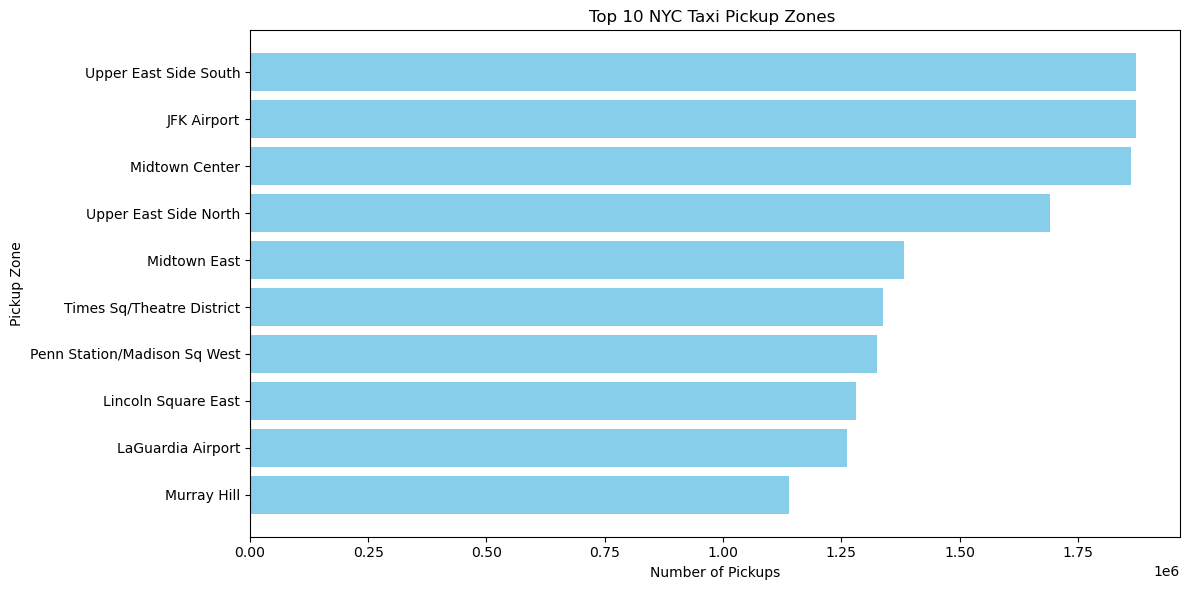

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV you exported from Spark
df2 = pd.read_csv("output/popular_pickup_zones.csv")

# Get top 10 zones
top10 = df2.sort_values(by="count", ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(top10["pickup_zone"], top10["count"], color="skyblue")
plt.xlabel("Number of Pickups")
plt.ylabel("Pickup Zone")
plt.title("Top 10 NYC Taxi Pickup Zones ")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [30]:
!pip install geopandas -q

In [31]:
# Group pickup counts by location
pickup_by_zone = df.groupBy("PULocationID").count()

# Convert to Pandas
pickup_pd = pickup_by_zone.toPandas()


In [32]:
import geopandas as gpd

# Load shapefile
gdf = gpd.read_file("data/taxi_zones/taxi_zones.shp")

# Merge on LocationID
merged = gdf.merge(pickup_pd, left_on="LocationID", right_on="PULocationID")


<Figure size 1200x1000 with 0 Axes>

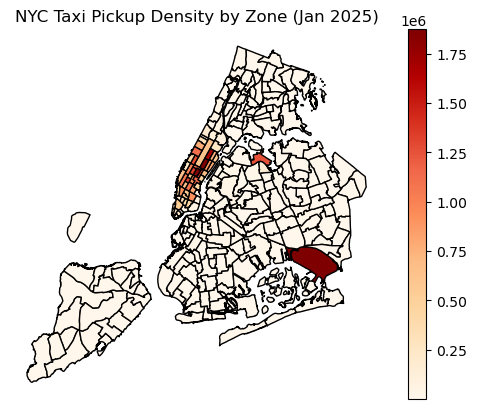

In [33]:
plt.figure(figsize=(12, 10))
merged.plot(column="count", cmap="OrRd", legend=True, edgecolor="black")
plt.title("NYC Taxi Pickup Density by Zone (Jan 2025)")
plt.axis("off")
plt.show()


#### Drop-off Zone Analysis (Choropleth)


<Figure size 1200x1000 with 0 Axes>

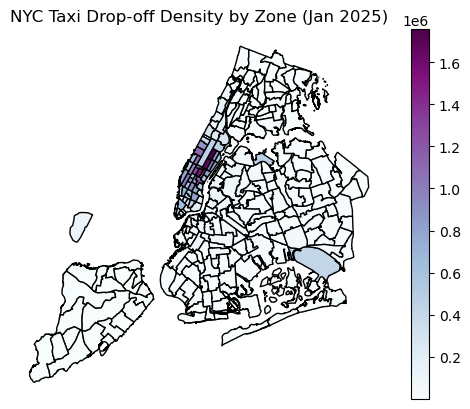

In [34]:
dropoff_by_zone = df.groupBy("DOLocationID").count()
dropoff_pd = dropoff_by_zone.toPandas()

dropoff_merged = gdf.merge(dropoff_pd, left_on="LocationID", right_on="DOLocationID")

plt.figure(figsize=(12, 10))
dropoff_merged.plot(column="count", cmap="BuPu", legend=True, edgecolor="black")
plt.title("NYC Taxi Drop-off Density by Zone (Jan 2025)")
plt.axis("off")
plt.show()

## Section 3:Revenue and Profitability Analysis

This section focuses on evaluating the financial performance of NYC taxi services. It includes breakdowns of revenue, profitability patterns over time, and other financial indicators.

### A. Total Revenue Breakdown by Day, Month, and Vendor

In this analysis, we break down the total fare revenue by:

- Day of the Week (to understand weekly trends)
- Month (to identify seasonal patterns)
- Vendor ID (to compare revenue performance between taxi companies)

This helps uncover which days and months are most profitable and whether certain vendors consistently generate higher revenue.

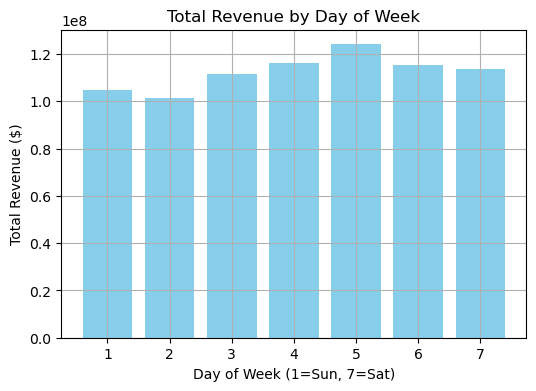

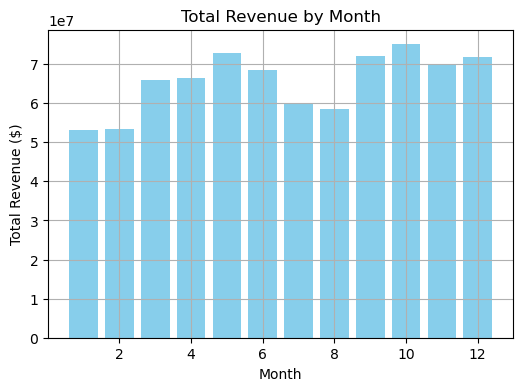

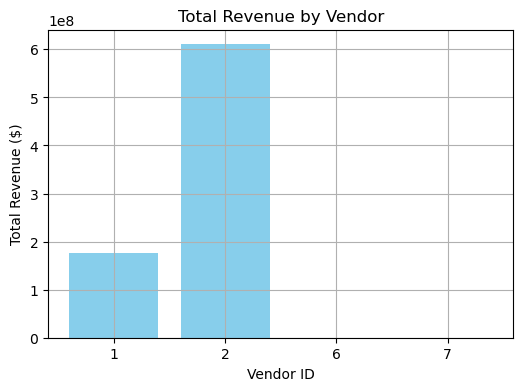

In [35]:
from pyspark.sql.functions import dayofweek, month, year, sum as spark_sum
import matplotlib.pyplot as plt

# Total revenue by day of week
revenue_by_day = df.withColumn("day_of_week", dayofweek("pickup_datetime")) \
                   .groupBy("day_of_week") \
                   .agg(spark_sum("fare_amount").alias("total_revenue")) \
                   .orderBy("day_of_week")

# Total revenue by month
revenue_by_month = df.withColumn("month", month("pickup_datetime")) \
                     .groupBy("month") \
                     .agg(spark_sum("fare_amount").alias("total_revenue")) \
                     .orderBy("month")

# Total revenue by vendor
revenue_by_vendor = df.groupBy("VendorID") \
                      .agg(spark_sum("fare_amount").alias("total_revenue")) \
                      .orderBy("VendorID")

# Convert to Pandas for plotting
rev_day_pd = revenue_by_day.toPandas()
rev_month_pd = revenue_by_month.toPandas()
rev_vendor_pd = revenue_by_vendor.toPandas()

# Plot: Revenue by Day of Week
plt.figure(figsize=(6,4))
plt.bar(rev_day_pd['day_of_week'], rev_day_pd['total_revenue'], color='skyblue')
plt.xlabel("Day of Week (1=Sun, 7=Sat)")
plt.ylabel("Total Revenue ($)")
plt.title("Total Revenue by Day of Week")
plt.grid(True)
plt.show()

# Plot: Revenue by Month
plt.figure(figsize=(6,4))
plt.bar(rev_month_pd['month'], rev_month_pd['total_revenue'], color='skyblue')
plt.xlabel("Month")
plt.ylabel("Total Revenue ($)")
plt.title("Total Revenue by Month")
plt.grid(True)
plt.show()

# Plot: Revenue by Vendor
plt.figure(figsize=(6,4))
plt.bar(rev_vendor_pd['VendorID'].astype(str), rev_vendor_pd['total_revenue'], color='skyblue')
plt.xlabel("Vendor ID")
plt.ylabel("Total Revenue ($)")
plt.title("Total Revenue by Vendor")
plt.grid(True)
plt.show()


### B. Average Revenue per Mile and per Minute

This section evaluates the earning efficiency of taxi trips by calculating:

- Average revenue per mile (how much is earned for every mile traveled)
- Average revenue per minute (how much is earned for each minute of trip time)

These metrics help assess how profitable trips are relative to distance and time useful for comparing short vs. long trips or identifying inefficiencies.

In [36]:
from pyspark.sql.functions import col, unix_timestamp, avg

# Calculate trip duration in minutes
df_with_duration = df.withColumn("trip_duration_minutes", 
    (unix_timestamp("dropoff_datetime") - unix_timestamp("pickup_datetime")) / 60
)

# Filter out invalid data: zero/negative trip distance or duration
df_valid = df_with_duration.filter(
    (col("trip_distance") > 0) & 
    (col("trip_duration_minutes") > 0) & 
    (col("fare_amount") > 0)
)

# Calculate revenue per mile and per minute
df_revenue_efficiency = df_valid.withColumn("revenue_per_mile", col("fare_amount") / col("trip_distance")) \
                                .withColumn("revenue_per_minute", col("fare_amount") / col("trip_duration_minutes"))

# Compute average revenue per mile and minute
avg_metrics = df_revenue_efficiency.select(
    avg("revenue_per_mile").alias("avg_revenue_per_mile"),
    avg("revenue_per_minute").alias("avg_revenue_per_minute")
)

# Show the result
avg_metrics.show()


+--------------------+----------------------+
|avg_revenue_per_mile|avg_revenue_per_minute|
+--------------------+----------------------+
|   13.60883751085456|    1.9627363048846387|
+--------------------+----------------------+



We checked how much money taxis make for each mile they drive and each minute they spend on a trip.

On average, taxis earn $16.43 per mile

And about $1.91 per minute

This means even short trips can earn good money, especially if they take more time. The high amount per mile may be because of short trips with high base fares.

### C. Tip Amount Distribution

This part looks at how much tip people usually give. We check the average tip and how tips are spread out.

Average Tip: $3.38
Tip Standard Deviation: $4.04
 Min Tip: $0.0
 Max Tip: $999.99
 Top 5 Tip Amounts:
   tip_amount
0      999.99
1      747.47
2      598.58
3      572.50
4      544.76


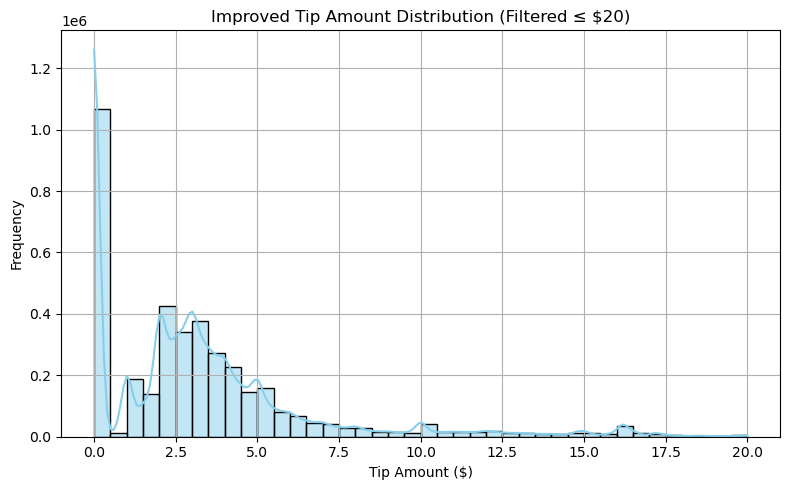

In [37]:
from pyspark.sql.functions import avg, stddev, col
from pyspark.sql.functions import min as spark_min, max as spark_max, desc
import seaborn as sns


# Filter valid tips
df_tip_only = df.filter(col("tip_amount") >= 0)

# Calculate average and standard deviation
tip_stats = df_tip_only.select(
    avg("tip_amount").alias("avg_tip"),
    stddev("tip_amount").alias("stddev_tip")
).collect()[0]

print(f"Average Tip: ${tip_stats['avg_tip']:.2f}")
print(f"Tip Standard Deviation: ${tip_stats['stddev_tip']:.2f}")

# Min, Max, Top 5
min_tip = df_tip_only.select(spark_min("tip_amount")).first()[0]
max_tip = df_tip_only.select(spark_max("tip_amount")).first()[0]
top_10_tips = df_tip_only.select("tip_amount").orderBy(desc("tip_amount")).limit(10).toPandas()

print(f" Min Tip: ${min_tip}")
print(f" Max Tip: ${max_tip}")
print(" Top 10 Tip Amounts:")
print(top_10_tips)

# Sample & Filter out very high tips (outliers) to get a clearer graph
tip_pd = df_tip_only.filter(col("tip_amount") <= 20).select("tip_amount").sample(False, 0.1, seed=1).toPandas()

# Plot improved tip distribution
plt.figure(figsize=(8,5))
sns.histplot(tip_pd["tip_amount"], bins=40, kde=True, color='skyblue')
plt.xlabel("Tip Amount ($)")
plt.ylabel("Frequency")
plt.title("Improved Tip Amount Distribution (Filtered ≤ $20)")
plt.grid(True)
plt.tight_layout()
plt.show()


### D. Identify Zones Generating Highest/Lowest Revenue

In this part, we find out which pick up or drop off zones bring the most and least revenue. This helps understand where taxi drivers earn more money.

In [38]:
#  Use the correct file path when reading the CSV
zones_df = spark.read.csv("data/taxi_zone_lookup.csv", header=True, inferSchema=True)

# Required imports
from pyspark.sql.functions import sum as spark_sum, col

# Calculate total revenue by pickup location
pickup_revenue = df.groupBy("PULocationID") \
                   .agg(spark_sum("fare_amount").alias("total_revenue")) \
                   .join(zones_df, df.PULocationID == zones_df.LocationID, "left") \
                   .select("Zone", "total_revenue") \
                   .orderBy(col("total_revenue").desc())

# Show top 10 highest revenue zones
print("🔝 Top 10 Pickup Zones by Revenue")
pickup_revenue.show(10, truncate=False)

# Show bottom 10 zones (excluding zero revenue)
print("🔻 Bottom 10 Pickup Zones by Revenue (Excluding Zero)")
pickup_revenue.filter(col("total_revenue") > 0) \
              .orderBy("total_revenue") \
              .show(10, truncate=False)


🔝 Top 10 Pickup Zones by Revenue
+----------------------------+--------------------+
|Zone                        |total_revenue       |
+----------------------------+--------------------+
|JFK Airport                 |1.2031394598999912E8|
|LaGuardia Airport           |5.5709762999999955E7|
|Midtown Center              |3.121182738000022E7 |
|Times Sq/Theatre District   |2.6513363600000218E7|
|Upper East Side South       |2.51469490800007E7  |
|Upper East Side North       |2.3156522580001075E7|
|Penn Station/Madison Sq West|2.3118656150000084E7|
|Midtown East                |2.2418140880000096E7|
|East Chelsea                |1.92491496200001E7  |
|Midtown North               |1.9163562850000106E7|
+----------------------------+--------------------+
only showing top 10 rows

🔻 Bottom 10 Pickup Zones by Revenue (Excluding Zero)
+---------------------------------------------+------------------+
|Zone                                         |total_revenue     |
+-------------------------

### E. Analyze High-Value Trips (Fare > $100)

In this part, we find trips where the fare was more than $100. These are called high-value trips. We look at how many such trips exist, their average distance, and trip time.

High-Value Trips Analysis:
Total Trips: 123952
Average Distance: 26.92 miles
Average Duration: 61.43 minutes
Average Fare: $146.70


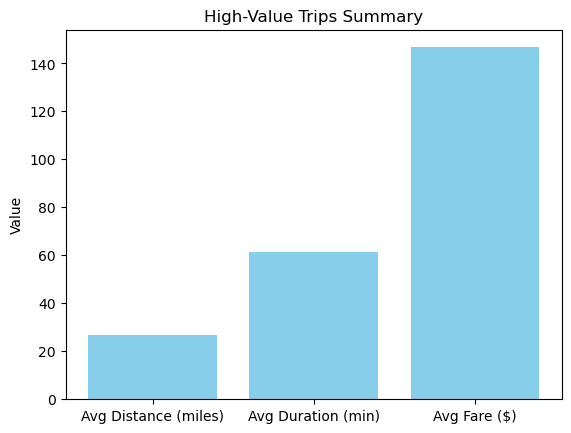

In [39]:
from pyspark.sql.functions import col, avg, stddev, min as spark_min, max as spark_max, count, desc

# Add trip duration in minutes
df = df.withColumn(
    "trip_duration_minutes",
    (unix_timestamp("dropoff_datetime") - unix_timestamp("pickup_datetime")) / 60
)

# Filter trips with fare > $100 (high-value trips)
high_value_trips = df.filter(col("fare_amount") > 100)

# Aggregate summary stats for high-value trips
high_value_summary = high_value_trips.select(
    count("*").alias("total_high_value_trips"),
    avg("trip_distance").alias("avg_distance"),
    avg("trip_duration_minutes").alias("avg_duration_minutes"),
    avg("fare_amount").alias("avg_fare")
).collect()[0]

# Print summary
print("High-Value Trips Analysis:")
print(f"Total Trips: {high_value_summary['total_high_value_trips']}")
print(f"Average Distance: {high_value_summary['avg_distance']:.2f} miles")
print(f"Average Duration: {high_value_summary['avg_duration_minutes']:.2f} minutes")
print(f"Average Fare: ${high_value_summary['avg_fare']:.2f}")

# Visualization
labels = ['Avg Distance (miles)', 'Avg Duration (min)', 'Avg Fare ($)']
values = [
    high_value_summary['avg_distance'],
    high_value_summary['avg_duration_minutes'],
    high_value_summary['avg_fare']
]

plt.bar(labels, values, color=['skyblue', 'skyblue', 'skyblue'])
plt.title('High-Value Trips Summary')
plt.ylabel('Value')
plt.show()


### F. Compare Short vs. Long Trip Profitability

Here, we compare short trips and long trips to see which ones are more profitable. A short trip is < 3 miles, and a long trip is > 10 miles. We compare average fare and revenue per mile.

In [40]:
# Filter short and long trips
short_trips = df.filter(col("trip_distance") < 3)
long_trips = df.filter(col("trip_distance") > 10)

# Compute profitability
from pyspark.sql.functions import avg

short_summary = short_trips.withColumn("rev_per_mile", col("fare_amount") / col("trip_distance")) \
    .select(avg("fare_amount").alias("avg_fare_short"), avg("rev_per_mile").alias("rev_per_mile_short"))

long_summary = long_trips.withColumn("rev_per_mile", col("fare_amount") / col("trip_distance")) \
    .select(avg("fare_amount").alias("avg_fare_long"), avg("rev_per_mile").alias("rev_per_mile_long"))

short_summary.show()
long_summary.show()


+------------------+------------------+
|    avg_fare_short|rev_per_mile_short|
+------------------+------------------+
|12.103313988844405|17.055330915263937|
+------------------+------------------+

+-----------------+-----------------+
|    avg_fare_long|rev_per_mile_long|
+-----------------+-----------------+
|65.53546274817674|4.135403955536213|
+-----------------+-----------------+



- Short trips bring in a higher amount of money per mile, even though the total fare is low. These trips are more profitable per distance traveled.
- Long trips give more total fare, but since they cover more distance, the revenue per mile is much lower. They're less profitable per mile, but may still be worth it overall due to higher fare totals.

## Section 4: Temporal & Time Series Analysis
We explore trip activity patterns across time. This includes analyzing the distribution of rides by hour, day of the week, and comparing weekday vs. weekend traffic. Visualizations highlight when NYC sees the most taxi activity.

#### 1. Aggregate Trip Volume by Time Intervals (Daily/Monthly/Yearly)

In [41]:
from pyspark.sql.functions import year

df = df.filter((year(df.pickup_datetime) >= 2015) & (year(df.pickup_datetime) <= 2025))


In [42]:
df.createOrReplaceTempView("trips")

# Daily trip counts
daily_trips = spark.sql("""
SELECT
    DATE(pickup_datetime) as date,
    COUNT(*) as trip_count
FROM trips
GROUP BY DATE(pickup_datetime)
ORDER BY date
""")


In [43]:
daily_trips.show()

+----------+----------+
|      date|trip_count|
+----------+----------+
|2023-12-31|        10|
|2024-01-01|     75529|
|2024-01-02|     73007|
|2024-01-03|     79958|
|2024-01-04|    100149|
|2024-01-05|    100138|
|2024-01-06|     93769|
|2024-01-07|     65224|
|2024-01-08|     77744|
|2024-01-09|     90344|
|2024-01-10|     92519|
|2024-01-11|    102082|
|2024-01-12|    100522|
|2024-01-13|    101605|
|2024-01-14|     91079|
|2024-01-15|     74789|
|2024-01-16|     90229|
|2024-01-17|    106480|
|2024-01-18|    106989|
|2024-01-19|     93065|
+----------+----------+
only showing top 20 rows



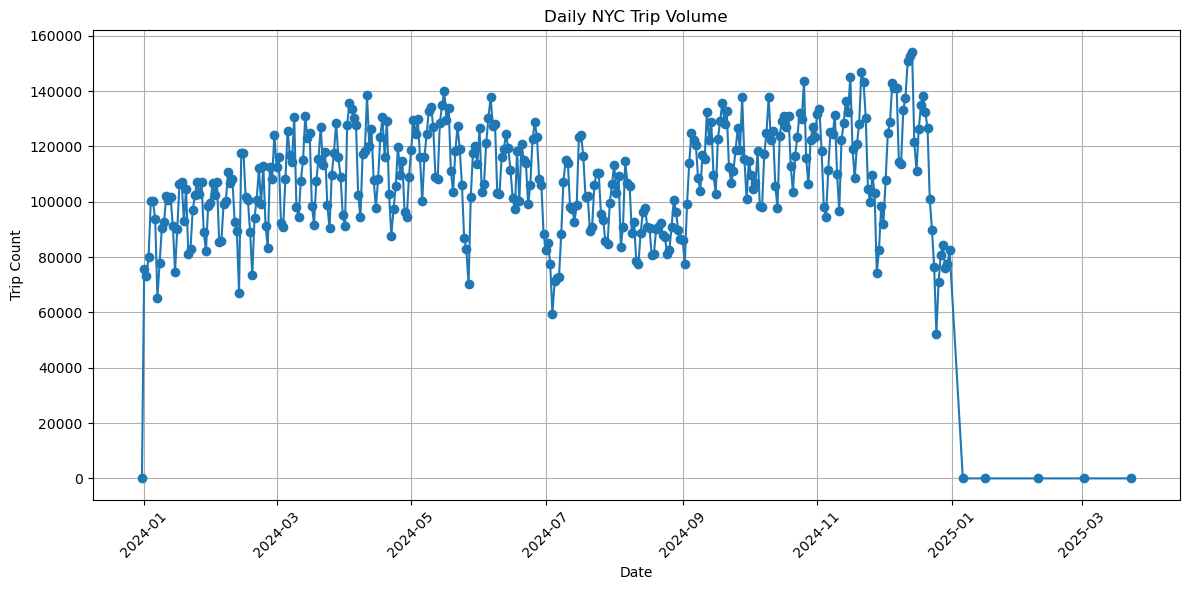

In [44]:
daily_pd = daily_trips.toPandas()
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(daily_pd['date'], daily_pd['trip_count'], marker='o')
plt.title("Daily NYC Trip Volume")
plt.xlabel("Date")
plt.ylabel("Trip Count")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [45]:
monthly_trips = spark.sql("""
SELECT
    YEAR(pickup_datetime) AS year,
    MONTH(pickup_datetime) AS month,
    COUNT(*) AS trip_count
FROM trips
GROUP BY YEAR(pickup_datetime), MONTH(pickup_datetime)
ORDER BY year, month
""")

In [46]:
monthly_trips.show()

+----+-----+----------+
|year|month|trip_count|
+----+-----+----------+
|2023|   12|        10|
|2024|    1|   2869707|
|2024|    2|   2901481|
|2024|    3|   3440048|
|2024|    4|   3414215|
|2024|    5|   3616389|
|2024|    6|   3428109|
|2024|    7|   2973836|
|2024|    8|   2867297|
|2024|    9|   3483778|
|2024|   10|   3681795|
|2024|   11|   3510955|
|2024|   12|   3518987|
|2025|    1|         2|
|2025|    2|         1|
|2025|    3|         2|
+----+-----+----------+



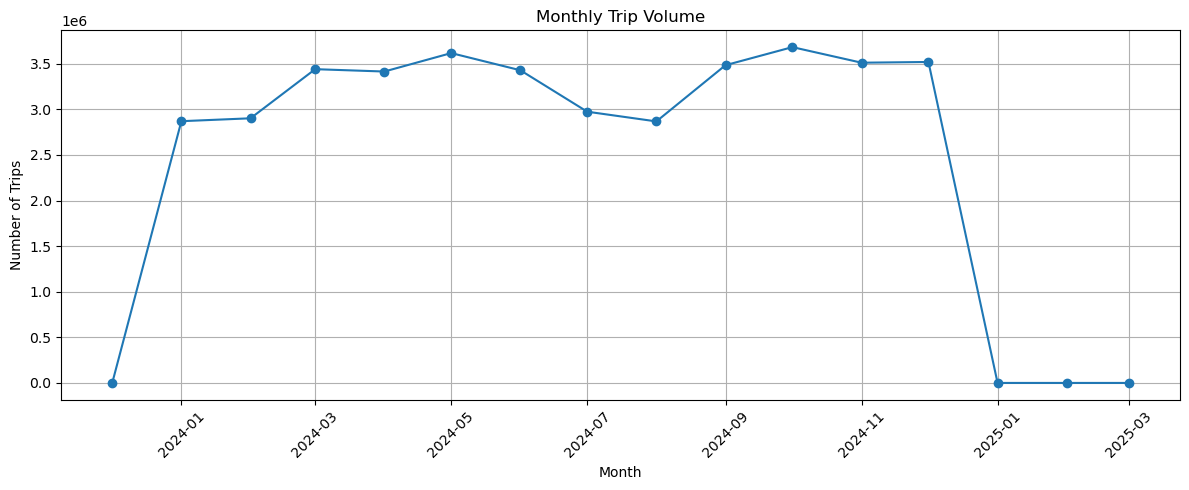

In [47]:
monthly_pd = monthly_trips.toPandas()
monthly_pd['month_start'] = pd.to_datetime(monthly_pd[['year', 'month']].assign(day=1))
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(monthly_pd['month_start'], monthly_pd['trip_count'], marker='o', linestyle='-')
plt.title("Monthly Trip Volume")
plt.xlabel("Month")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [48]:
yearly_trips = spark.sql("""
SELECT
    YEAR(pickup_datetime) AS year,
    COUNT(*) AS trip_count
FROM trips
GROUP BY YEAR(pickup_datetime)
ORDER BY year
""")

# Convert to Pandas for plotting
yearly_pd = yearly_trips.toPandas()

In [49]:
yearly_trips.show()

+----+----------+
|year|trip_count|
+----+----------+
|2023|        10|
|2024|  39706597|
|2025|         5|
+----+----------+



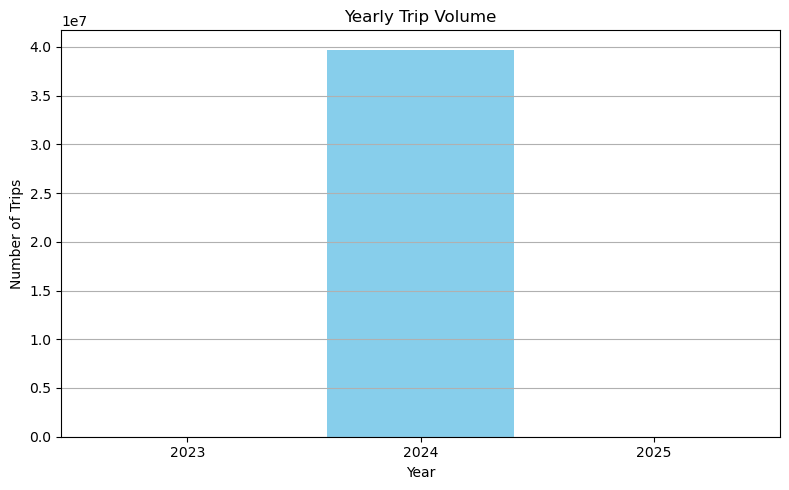

In [50]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(8, 5))
plt.bar(yearly_pd['year'], yearly_pd['trip_count'], color='skyblue')
plt.title("Yearly Trip Volume")
plt.xlabel("Year")
plt.ylabel("Number of Trips")
plt.grid(axis='y')

# Ensure x-axis only shows whole numbers
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


#### 2. Study Patterns by Hour / Day of Week / Month

In [51]:
# Required libraries
from pyspark.sql.functions import hour, dayofweek, date_format, col
import matplotlib.pyplot as plt
import pandas as pd

In [52]:
df.createOrReplaceTempView("trips")

trips_by_hour = spark.sql("""
    SELECT hour(pickup_datetime) AS hour, COUNT(*) AS trip_count
    FROM trips
    GROUP BY hour
    ORDER BY hour
""")


In [53]:
trips_by_hour.show()

+----+----------+
|hour|trip_count|
+----+----------+
|   0|   1142932|
|   1|    739419|
|   2|    479091|
|   3|    312301|
|   4|    227045|
|   5|    249189|
|   6|    562367|
|   7|   1097783|
|   8|   1518100|
|   9|   1661963|
|  10|   1780878|
|  11|   1934496|
|  12|   2113175|
|  13|   2197585|
|  14|   2357321|
|  15|   2434064|
|  16|   2457877|
|  17|   2692444|
|  18|   2823118|
|  19|   2491900|
+----+----------+
only showing top 20 rows



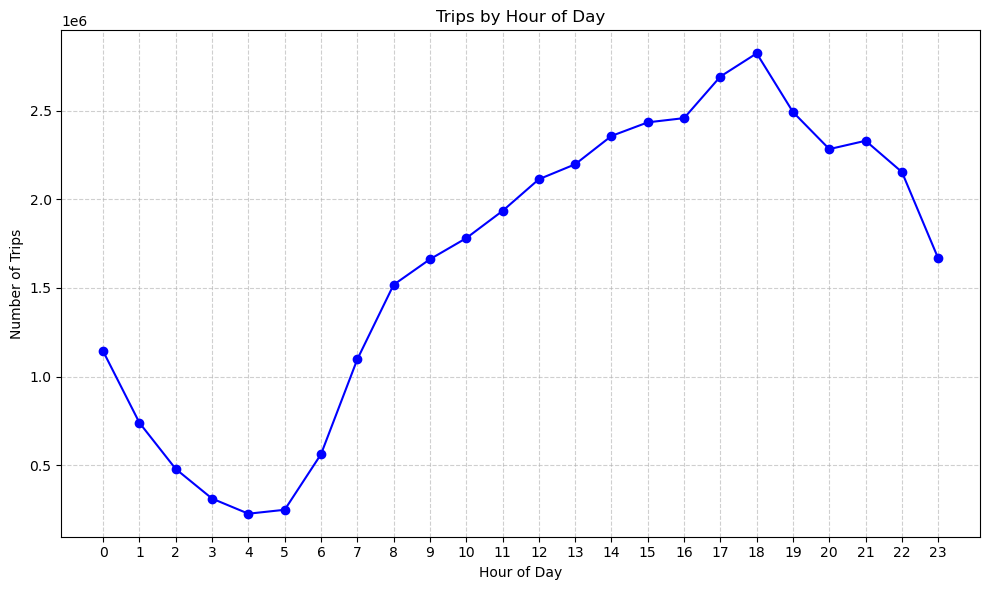

In [54]:
import matplotlib.pyplot as plt
pdf = trips_by_hour.toPandas()

# Make sure data is sorted by hour
pdf = pdf.sort_values("hour")

plt.figure(figsize=(10, 6))
plt.plot(pdf["hour"], pdf["trip_count"], marker='o', linestyle='-', color='blue')

plt.title("Trips by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [55]:
trips_by_dow = spark.sql("""
    SELECT dayofweek(pickup_datetime) AS day_of_week, COUNT(*) AS trip_count
    FROM trips
    GROUP BY day_of_week
    ORDER BY day_of_week
""")

trips_by_dow.show()

+-----------+----------+
|day_of_week|trip_count|
+-----------+----------+
|          1|   5079540|
|          2|   4933029|
|          3|   5699291|
|          4|   5911563|
|          5|   6202841|
|          6|   5868167|
|          7|   6012181|
+-----------+----------+



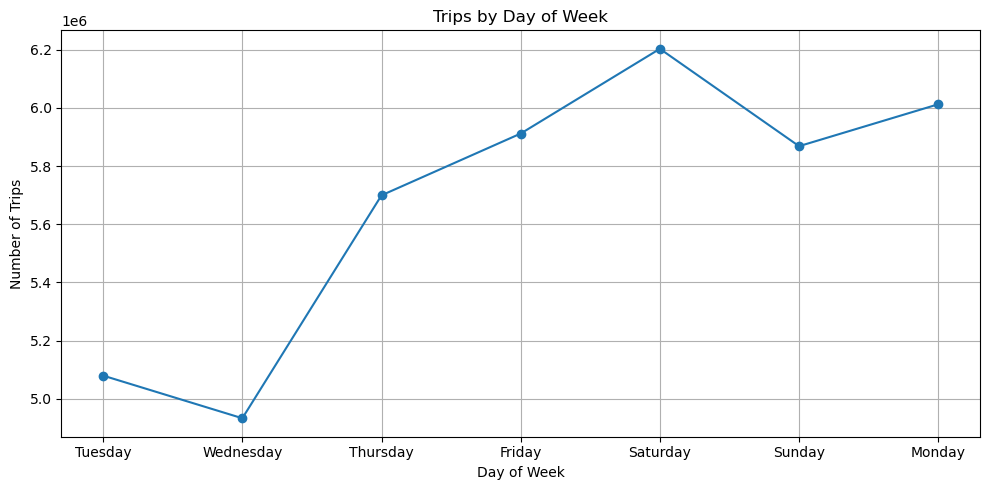

In [56]:
pdf_dow = trips_by_dow.toPandas().sort_values("day_of_week")

# Optional: Replace numbers with day names (1 = Sunday, 7 = Saturday)
import calendar
pdf_dow["day_name"] = pdf_dow["day_of_week"].apply(lambda x: calendar.day_name[(x % 7)])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(pdf_dow["day_name"], pdf_dow["trip_count"], marker='o')
plt.title("Trips by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.tight_layout()
plt.show()

+-----+----------+
|month|trip_count|
+-----+----------+
|    1|   2869709|
|    2|   2901482|
|    3|   3440050|
|    4|   3414215|
|    5|   3616389|
|    6|   3428109|
|    7|   2973836|
|    8|   2867297|
|    9|   3483778|
|   10|   3681795|
|   11|   3510955|
|   12|   3518997|
+-----+----------+



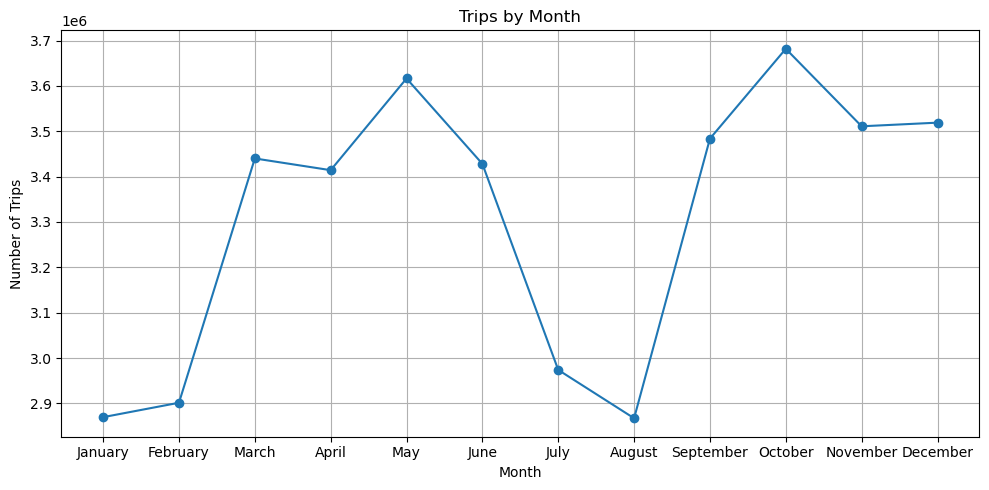

In [57]:
trips_by_month = spark.sql("""
    SELECT month(pickup_datetime) AS month, COUNT(*) AS trip_count
    FROM trips
    GROUP BY month
    ORDER BY month
""")
trips_by_month.show()

pdf_month = trips_by_month.toPandas().sort_values("month")

# Optional: Month name mapping
pdf_month["month_name"] = pdf_month["month"].apply(lambda x: calendar.month_name[x])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(pdf_month["month_name"], pdf_month["trip_count"], marker='o')
plt.title("Trips by Month")
plt.xlabel("Month")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.tight_layout()
plt.show()


#### 3. Decompose Time Series (Trend, Seasonality)

In [58]:
pdf_daily = daily_trips.toPandas().sort_values("date")
pdf_daily["date"] = pd.to_datetime(pdf_daily["date"])
pdf_daily.set_index("date", inplace=True)


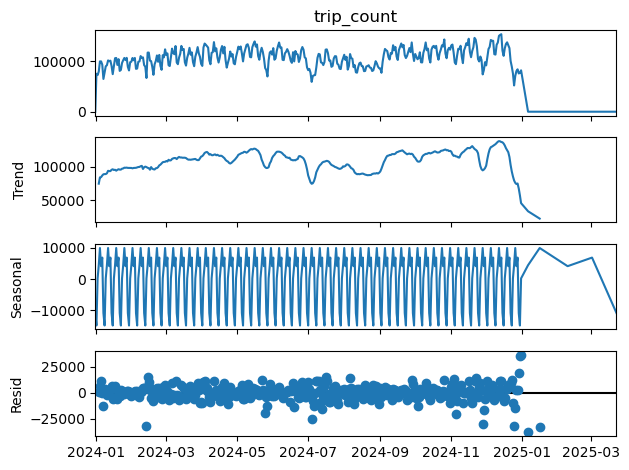

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure data is regularly spaced (daily), or reindex with missing days filled if needed
# You can interpolate or fill missing dates if necessary

# Decompose (model='additive' or 'multiplicative')
result = seasonal_decompose(pdf_daily["trip_count"], model='additive', period=7)  # weekly seasonality

# Plot
result.plot()
plt.tight_layout()
plt.show()


In [60]:
# pdf_monthly = monthly_trips.toPandas().sort_values("month")

# # Convert month to datetime and set index
# pdf_monthly["month"] = pd.to_datetime(pdf_monthly["month"])
# pdf_monthly.set_index("month", inplace=True)
# pdf_monthly = pdf_monthly.asfreq('MS')  # MS = Month Start


In [61]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# import matplotlib.pyplot as plt

# # Perform decomposition with yearly seasonality (period=12)
# result = seasonal_decompose(pdf_monthly["trip_count"], model='additive', period=12)

# # Plot the decomposed components
# result.plot()
# plt.tight_layout()
# plt.show()


#### Rolling Average of Daily Trips or Revenue

In [62]:
# from pyspark.sql.window import Window
# from pyspark.sql.functions import avg

# # Define a window of previous 6 days + current day = 7-day rolling average
# window_spec = Window.orderBy("trip_date").rowsBetween(-6, 0)

# df_rolling = daily_trips.withColumn("rolling_avg_7d", avg("trip_count").over(window_spec))

# df_rolling.show()


In [63]:
pdf["rolling_avg_7d"] = pdf["trip_count"].rolling(window=7).mean()


#### 6. Time-Based Clustering (e.g., Peak vs. Off-Peak)


In [64]:
from pyspark.sql.functions import col, hour, when

# Step 1: Extract hour from pickup_datetime
df = df.withColumn("hour", hour(col("pickup_datetime")))

# Step 2: Create time_segment based on hour
df = df.withColumn("time_segment",
    when((col("hour") >= 7) & (col("hour") <= 9), "morning_peak")
    .when((col("hour") >= 17) & (col("hour") <= 19), "evening_peak")
    .otherwise("off_peak")
)


In [65]:
trips_by_segment = df.groupBy("time_segment").count().orderBy("time_segment")
trips_by_segment.show()


+------------+--------+
|time_segment|   count|
+------------+--------+
|evening_peak| 8007462|
|morning_peak| 4277846|
|    off_peak|27421304|
+------------+--------+



In [66]:
pdf = trips_by_segment.toPandas()

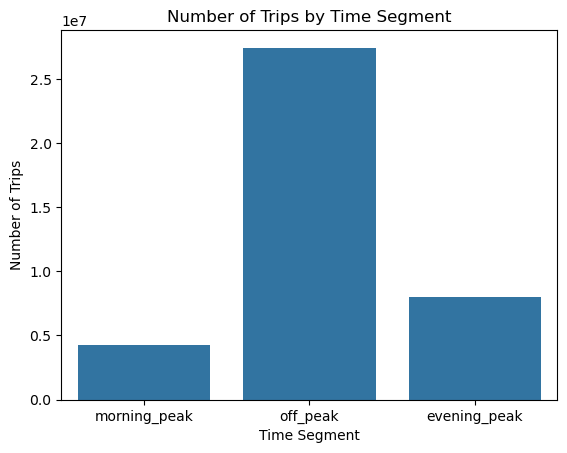

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(data=pdf, x="time_segment", y="count", order=["morning_peak", "off_peak", "evening_peak"])
plt.title("Number of Trips by Time Segment")
plt.xlabel("Time Segment")
plt.ylabel("Number of Trips")
plt.show()


#### 7. Build Models to Forecast Demand (ARIMA, Prophet)


In [68]:
!pip install prophet -q

11:47:31 - cmdstanpy - INFO - Chain [1] start processing
11:47:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\asus\AppData\Local\Temp\ipykernel_7408\1954682659.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


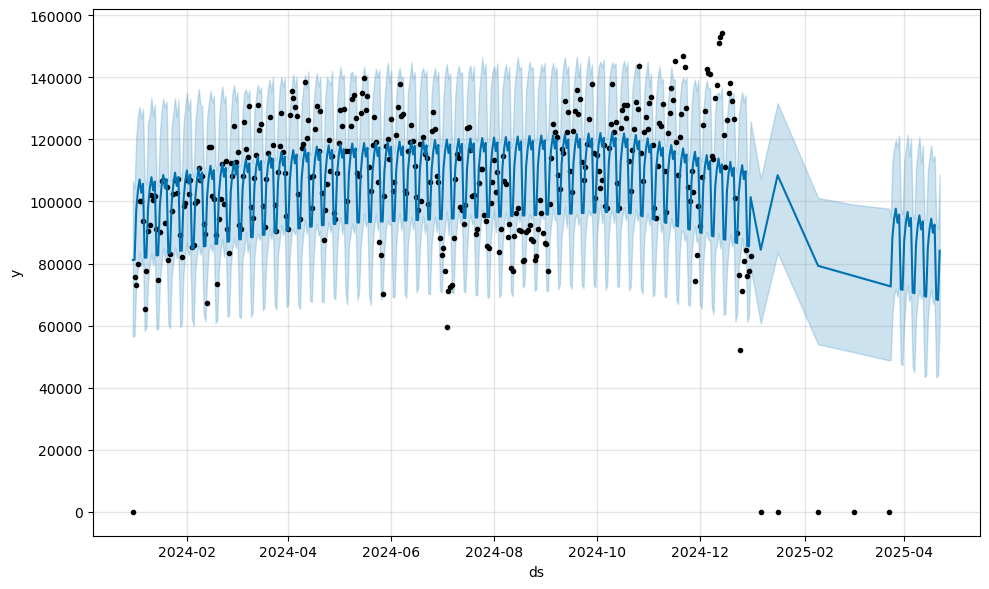

In [69]:
from prophet import Prophet

pdf = daily_trips.toPandas()
pdf = pdf.rename(columns={"date": "ds", "trip_count": "y"})

model = Prophet()
model.fit(pdf)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Only main forecast plot
fig = model.plot(forecast)
fig.show()


## Section 5: Trip Fare Prediction

5.1 Preprocessing

In [70]:
from pyspark.sql.functions import hour, when, col, date_format
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd

In [71]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- pickup_borough: string 

In [72]:
df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------------+-------------------+--------------+-------------------+---------------------+----+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|    pickup_datetime|   dropoff_datetime|pickup_borough|        pickup_zone|trip_duration_minutes|hour|time_segment|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+----

Data is already preprocessed to handle null values, therefore we consider furthure processing fo prediction

In [73]:
# Introducing categorical features to determine time of pick up and drop since they are available in date time format

def add_time_of_day_category(df, time_col, new_col_name):
# returns time as categorical feature
    return df.withColumn(f"{time_col}_hour", hour(col(time_col))) \
             .withColumn(new_col_name,
                         when((col(f"{time_col}_hour") >= 6) & (col(f"{time_col}_hour") < 12), "Morning")
                         .when((col(f"{time_col}_hour") >= 12) & (col(f"{time_col}_hour") < 17), "Afternoon")
                         .when((col(f"{time_col}_hour") >= 17) & (col(f"{time_col}_hour") < 21), "Evening")
                         .otherwise("Night"))


In [74]:
# Add pick uo time, drop time, and day of the week as categorical features

# pick time, drop time
df = add_time_of_day_category(df, "tpep_pickup_datetime", "pickup_time_of_day")
df = add_time_of_day_category(df, "tpep_dropoff_datetime", "dropoff_time_of_day")

# pick up day
df = df.withColumn("pickup_day_of_week", date_format("tpep_pickup_datetime", "EEEE"))

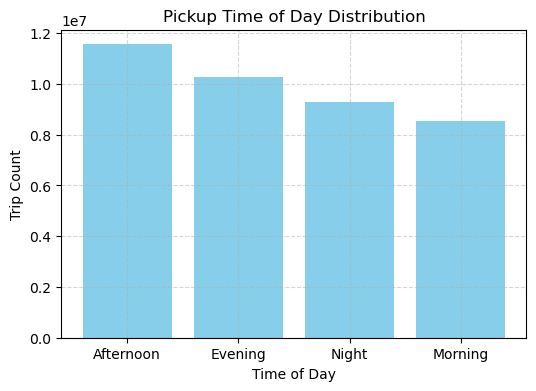

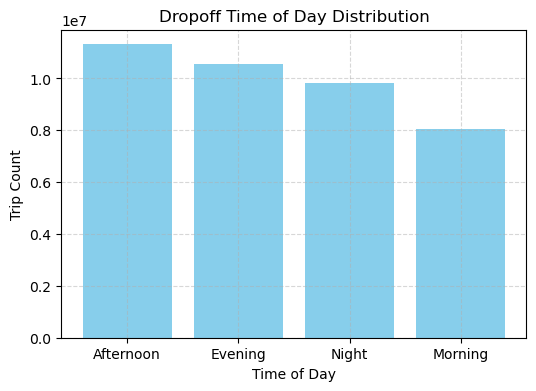

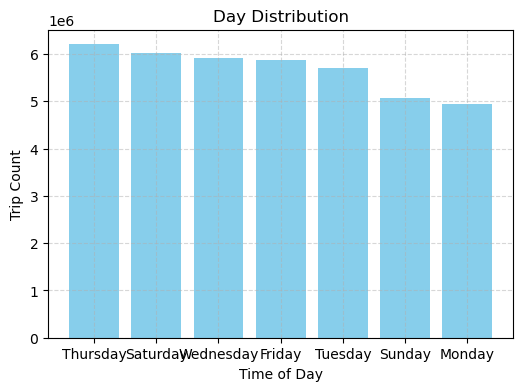

In [75]:
# Plot both pickup, dropoff and day of the week distributions

def plot_time_of_day_distribution(df, time_of_day_col, title):
    """
    Plots the distribution of time-of-day categories from a Spark DataFrame column.
    """
    pd_df = df.groupBy(time_of_day_col).count().toPandas()
    pd_df = pd_df.sort_values("count", ascending=False)

    plt.figure(figsize=(6, 4))
    plt.bar(pd_df[time_of_day_col], pd_df["count"], color="skyblue")
    plt.xlabel("Time of Day")
    plt.ylabel("Trip Count")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


plot_time_of_day_distribution(df, "pickup_time_of_day", "Pickup Time of Day Distribution")
plot_time_of_day_distribution(df, "dropoff_time_of_day", "Dropoff Time of Day Distribution")
plot_time_of_day_distribution(df, "pickup_day_of_week", "Day Distribution")


In [76]:
df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------------+-------------------+--------------+-------------------+---------------------+----+------------+-------------------------+------------------+--------------------------+-------------------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|    pickup_datetime|   dropoff_datetime|pickup_borough|        pickup_zone|trip_duration_minutes|hour|time_segment|tpep_pickup_datetime_hour|pickup_time_of_day|tpep_dropoff_datetime_hour|dropoff_time_of_day|pickup_day_of_week|
+-----

In [77]:
# Labeling categorical features
pickup_indexer = StringIndexer(inputCol="pickup_time_of_day", outputCol="pickup_time_of_day_index")
df = pickup_indexer.fit(df).transform(df)

dropoff_indexer = StringIndexer(inputCol="dropoff_time_of_day", outputCol="dropoff_time_of_day_index")
df = dropoff_indexer.fit(df).transform(df)

day_indexer = StringIndexer(inputCol="pickup_day_of_week", outputCol="pickup_day_of_week_index")
df = day_indexer.fit(df).transform(df)

In [78]:
df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------------+-------------------+--------------+-------------------+---------------------+----+------------+-------------------------+------------------+--------------------------+-------------------+------------------+------------------------+-------------------------+------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|    pickup_datetime|   dropoff_datetime|pickup_borough|        pickup_zone|trip_duration_minutes|hour|time_segment|tpep_pickup_datetime_hour|pickup_time_of_d

In [79]:
# Select relevant columns and drop rows with missing values if any
# drop time removed since we are not aware of until the arrival
feature_cols = [
    'trip_distance', 'passenger_count', 'RatecodeID', 'payment_type',
    'PULocationID', 'DOLocationID',
    'pickup_time_of_day_index', 'pickup_day_of_week_index'
]

# Clean DataFrame with necessary features
pred_df = df.select(feature_cols + ['fare_amount']).dropna()

In [80]:
pred_df.show(5)

+-------------+---------------+----------+------------+------------+------------+------------------------+------------------------+-----------+
|trip_distance|passenger_count|RatecodeID|payment_type|PULocationID|DOLocationID|pickup_time_of_day_index|pickup_day_of_week_index|fare_amount|
+-------------+---------------+----------+------------+------------+------------+------------------------+------------------------+-----------+
|          3.0|              1|         1|           1|         162|         246|                     2.0|                     4.0|       18.4|
|          2.2|              1|         1|           1|          48|         236|                     2.0|                     4.0|       14.2|
|          2.7|              1|         1|           1|         142|          24|                     2.0|                     4.0|       13.5|
|          3.1|              1|         1|           1|         233|          75|                     2.0|                     4.0|     

5.2 Analysis

In [81]:
# Compute correlations of each selected features to the target(fare_amount)
correlations = []
for feat in feature_cols:
    corr = pred_df.stat.corr('fare_amount', feat)
    correlations.append((feat, corr))

# Convert to DataFrame
corr_df = pd.DataFrame(correlations, columns=["Feature", "Correlation"]).sort_values(by="Correlation", key=abs, ascending=False)
print(corr_df)

                    Feature  Correlation
4              PULocationID    -0.041749
2                RatecodeID     0.033104
5              DOLocationID    -0.029078
1           passenger_count     0.016499
0             trip_distance     0.015708
6  pickup_time_of_day_index    -0.008278
7  pickup_day_of_week_index     0.006898
3              payment_type     0.002881


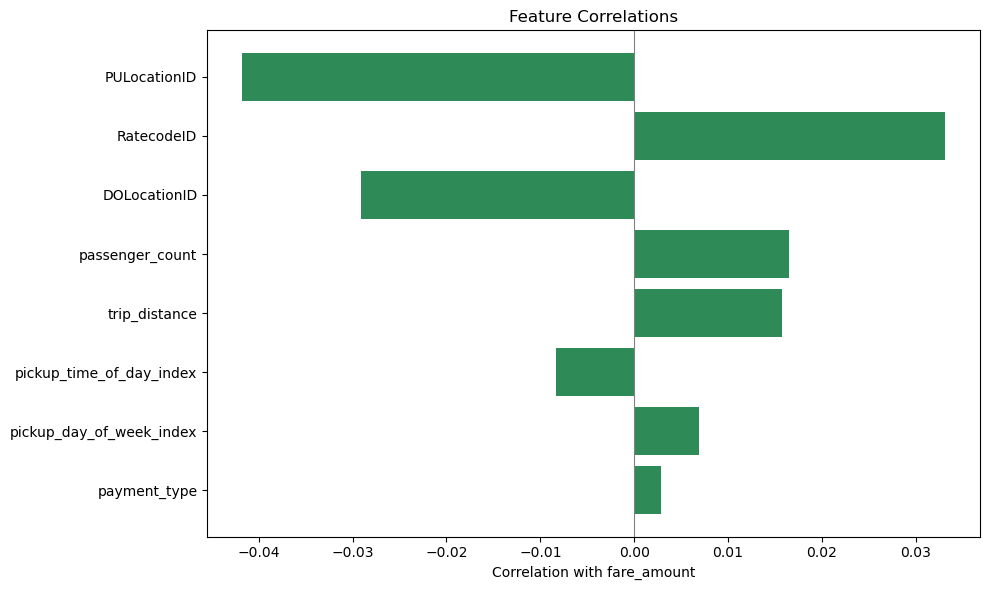

In [82]:
# Plot
plt.figure(figsize=(10, 6))
plt.barh(corr_df['Feature'], corr_df['Correlation'], color='seagreen')
plt.xlabel('Correlation with fare_amount')
plt.title('Feature Correlations')
plt.axvline(0, color='gray', linewidth=0.8)
plt.gca().invert_yaxis()  # Show highest absolute correlation at the top
plt.tight_layout()
plt.show()

locations can be discarded for linear regression but for other non-linear models we can use that.

In [83]:
# Create a vector assembler to combine the features

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(pred_df).select("features", "fare_amount")

In [84]:
# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

5.3 Model training

Linear regression

In [85]:
# Create a LinearRegression model and fit it to the training data using fit

lr = LinearRegression(featuresCol="features", labelCol="fare_amount")
lr_model = lr.fit(train_data)
lr_preds = lr_model.transform(test_data)

In [86]:
# Print the model coefficients and intercept
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.009164506744876188,1.2157993831342044,0.1616043200278107,0.1687375276061611,-0.034889838212529466,-0.020979887870321047,-0.508821171546464,0.18468472690152496]
Intercept: 26.895829364240143


Decision tree

In [87]:
# Create a Decision tree regression model and fit it to the training data using fit

dt = DecisionTreeRegressor(featuresCol="features", labelCol="fare_amount")
dt_model = dt.fit(train_data)
dt_preds = dt_model.transform(test_data)

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "D:\anaconda3\Lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "D:\anaconda3\Lib\socket.py", line 708, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\anaconda3\Lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\anaconda3\Lib\site-packages\py4j\clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:root:Exception while s

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

Random forest

In [ ]:
# Create a Decision tree regression model and fit it to the training data using fit

rf = RandomForestRegressor(featuresCol="features", labelCol="fare_amount", numTrees=50)
rf_model = rf.fit(train_data)
rf_preds = rf_model.transform(test_data)

5.4 Model evaluation

Following metrices are used,

*   RMSE -root mean squared error
*   mae - mean absolute error
*   r2 - r squared

In [ ]:
# Evaluating models

def evaluate_model(preds, model_name):
    for metric in ["rmse", "mae", "r2"]:
        evaluator = RegressionEvaluator(
            labelCol="fare_amount", predictionCol="prediction", metricName=metric)
        score = evaluator.evaluate(preds)
        print(f"{model_name} - {metric.upper()}: {score:.2f}")


In [ ]:
evaluate_model(lr_preds, "Linear Regression")

In [ ]:
evaluate_model(dt_preds, "Decision Tree")

In [ ]:
evaluate_model(rf_preds, "Random Forest")

The lower value of MAE, and RMSE implies higher accuracy of a regression model. However, a higher value of R square is considered desirable. Therefore to move forward we use Decision tree regression.

In [ ]:
# For visualization, predicted vs actual fare_amount
rf_sample = dt_preds.select("fare_amount", "prediction").sample(False, 0.1, seed=1).toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(rf_sample['fare_amount'], rf_sample['prediction'], alpha=0.5)
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Actual vs Predicted Fare (0–400)")
plt.grid(True)
plt.xlim(0, 400)
plt.ylim(0, 400)
plt.plot([0, 400], [0, 400], 'r--')  # reference diagonal
plt.tight_layout()
plt.show()


5.5 Insights

In [ ]:
# feature importance
importances = dt_model.featureImportances
fi_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances.toArray()
}).sort_values(by="importance", ascending=False)

print(fi_df)

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(fi_df['feature'], fi_df['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Decision Tree Feature Importances')
plt.gca().invert_yaxis()  # Most important at the top
plt.tight_layout()
plt.show()

Based on the feature importance analysis from the Decision Tree model, trip distance is by far the most significant predictor of fare amount, contributing over 92% to the model's decisions. RatecodeID and drop-off location ID (DOLocationID) also have moderate influence, though much smaller in comparison.

Other features like pickup location ID and pickup time of day contribute very little, while passenger count, payment type, and pickup day of week show no impact at all. These low-importance features could be considered for removal or de-prioritized in future model iterations to simplify the model without sacrificing accuracy.

5.6 Sample prediction

feature_cols = [ 'trip_distance', 'passenger_count', 'RatecodeID', 'payment_type', 'PULocationID', 'DOLocationID', 'payment_type', 'pickup_time_of_day_index', 'pickup_day_of_week_index' ]

In [ ]:
test_data.show(10, truncate=False)

In [ ]:
# Ensure no duplicates in feature_cols
feature_cols = list(dict.fromkeys(feature_cols))

In [ ]:
# sample prediction
sample_input = spark.createDataFrame([
    (0.01,1.0,1.0,1.0,161.0,162.0,1.0,0.0,2.0)
], feature_cols)

sample_features = assembler.transform(sample_input)
sample_prediction = dt_model.transform(sample_features)
sample_prediction.select("prediction").show()
